# Kotlin DataFrame: Getting Started

## What is this

This is the short introduction for those Kotlin developers, who are familiar at least with syntax and basic concepts of Kotlin

## What is this **not**

This is not a guide which will help you to migrate from another language or technology to Kotlin DataFrame

## What is Kotlin DataFrame

_From now on I will refer to this library as "KotlinDF". Albeit the fact it is not official name, it's much shorter and comfortable to use._

KotlinDF is a library to work with DataFrames. DataFrame is simple representation of any table-like data, that basically has columns and rows. Anyone who've seen products like MS Excel is already familiar with DF: one can add/remove/operate on columns/rows/cells, name etc.

But of course programming gives us very powerful tools which are hard to use in spreadsheet editors — for example, aggregations.

## Getting started

### Task

https://movielens.org/ is online service, providing recommendations based on user's taste. User may grade any movie from on a scale from 1 to 10 and some algorithm will give them recommendations based on their taste and taste of other users.

Indeed, this service should contain comprehensive informtion about movies and, of course, lots of information produced by users, for example tags.

You can obtain data [here](https://grouplens.org/datasets/movielens/), so will do I.

Today we're going to dig following information:

1. Find the most popular genre of movies since 1920
1. Find the most tagged movie

### Find the most popular genre of movies since 1920

To query data we should at first read data. Read it to DF in our case. That's how we do it:

In [1]:
%use dataframe(0.8.0-dev-576-0.11.0.6)
val rawMovies = DataFrame.read("ml-latest/movies.csv")

Yes, that simple! KotlinDF determines format itself and load the data into value, called `movies`. But how should we query this data, we don't even know how doe sit look like. Let's explore it.

The very basic will do the magic and will output the result:


In [2]:
rawMovies.head()

DataFrame [5 x 3]

The structure is simple, right? Just three columns:

1. movieId
1. title
1. genres

_NB: Interesting observation: without any effort from our side KotlinDF already determined type of each column._

And also we can already see the way to solve our first task. What do we eed to do?

1. Extract the year to separate column
1. If the year is not known — remove the movie from our DF — it's not relevant for us
1. Remove the year from the title (because it's not an actual part of title)
1. If genre is `(no genres listed)` — remove the movie from our DF — it's irrelevant for us
1. Split genres by `|` simple
1. Convert each row with multiple genres with multiple rows single genre each
1. Group the data by year and genre
1. Count the number of movies in each year-genre bucket

#### Extract the year to separate column

To add a column, based on another column we can use the `add` function. In our case it will look like this:

In [3]:
val moviesWithYear = rawMovies
    .add("year" /*①*/){ 
        "\\d{4}".toRegex() /*②*/.findAll(title/*③*/).lastOrNull()/*④*/?.value?.toInt/*⑤*/() ?: -1 /*⑥*/
    }

Let's look at all interesting places in this expression.

- ① - We're adding a column named `year`
- ② - To add column we'll use a regular expression `\\d{4}`, that just looks for any consecutive 4 digits
- ③ - thank to jupyter magic we can call the column just by name! In other environments syntax may be a bit more cluttered, for example `"title"<String>()`. _This feature will be available outside of jupyter in future releases._
- ④ - We are looking for the latest possible appearance of 4-digit sequences, or, if there are no such sequences returning `null`.
- ⑤ - If it exists we're casting it to `Int`
- ⑥ - Otherwilse we're returning `-1`. We have  strong belief that there were no movies filmed before 0 AD.
 
Let's check if we've achieved our first goal, by calling `head` again. The output is


In [4]:
moviesWithYear.head()

DataFrame [5 x 4]

Looks fine!

#### Now let's remove year from the title

For this we will use the `update` function. Regex here looks complex, so here is the small explanation of it:

```java
"\\s" +        // Match a single character that is a “whitespace character”
   "*" +         // Between zero and unlimited times, as many times as possible, giving back as needed
"\\\(" +        // Match the opening parenthesis character
"\\d" +        // Match a single character that is a “digit”
   "{4}" +       // Exactly 4 times
"\\\)" +        // Match the closing parenthesis character
"\\s" +        // Match a single character that is a “whitespace character”
   "*" +         // Between zero and unlimited times, as many times as possible, giving back as needed
"$"           // Assert position at the end of the string, or before the line break at the end of the string, if any
```

In [5]:
val movies = moviesWithYear
                .update("title"){
                    "\\s*\\(\\d{4}\\)\\s*$".toRegex().replace(title, "")
                }

####  Remove the movies with older than 1920

Filtering is quite easy, we need to just call the `filter function`, like this:


In [6]:
movies
    .filter { year >= 1920 }

... showing only top 20 of 57309 rows DataFrame [57309 x 4]

#### Remove lines where genre is `(no genres listed)`

It's quite a simple operation again, just one more filter

In [7]:
movies
    .filter { year >= 1920 }
    .filter { genres  != "(no genres listed)" }

... showing only top 20 of 53353 rows DataFrame [53353 x 4]

Or you can do everything in one filter

In [8]:
movies
    .filter { year >= 1920 && genres != "(no genres listed)" }

... showing only top 20 of 53353 rows DataFrame [53353 x 4]

#### Split genres by `|` symbol

Here we meet the next exciting concept of KotlinDF: built-in column operations. Most of them should be called right on dataframe! One of them is the `split` operation.

In [9]:
movies
    .filter { year >= 1920 && genres  != "(no genres listed)" }
    .split { genres }.by("|").inplace()

... showing only top 20 of 53353 rows DataFrame [53353 x 4]

_NB: the whole `split` operation is type-safe. We cannot call other operations on DF until we will finish splitting._

`inplace` here means that we want to replace current `genres` column with new content: String with array of strings.

#### Convert each row with multiple genres with multiple rows single genre each

There is a special `explode` function right for this task! And again, despite it being an operation on column we can pretend that we're performing it on DF.

In [10]:
movies
    .filter { year >= 1920 && genres  != "(no genres listed)" }
    .split { genres }.by("|").inplace()
    .explode { genres }

... showing only top 20 of 101106 rows DataFrame [101106 x 4]

To make it even easier, we can immediately split the column into lines.

In [11]:
movies
    .filter { year >= 1920 && genres  != "(no genres listed)" }
    .split { genres }.by("|").intoRows()

... showing only top 20 of 101106 rows DataFrame [101106 x 4]

Now, when the data is denormalised enough, analytics starts!

#### Grouping

First thing we should do here is to group the data by year and genre

In [12]:
movies
    .filter { year >= 1920 && genres  != "(no genres listed)" }
    .split { genres }.by("|").intoRows()
    .groupBy { year and genres }

... showing only top 20 of 1729 rows GroupBy

_Several interesting obsevations here_

1. we have a synthetic column called `group` here, that contains dataframes inside. This means that DataFrames here are first-class citizens. DFs can contain other DFs up to infinite depth!
1. Returned type from previous is of type `GroupedDataFrame`, that allows us to perform special *aggregation* operations

#### Counting movies in groups

In [13]:
movies
    .filter { year >= 1920 && genres  != "(no genres listed)" }
    .split { genres }.by("|").intoRows()
    .groupBy { year and genres }
    .count()
    .sortBy { year.desc() and genres }

... showing only top 20 of 1729 rows DataFrame [1729 x 3]

Let's visualize this data and we'll see

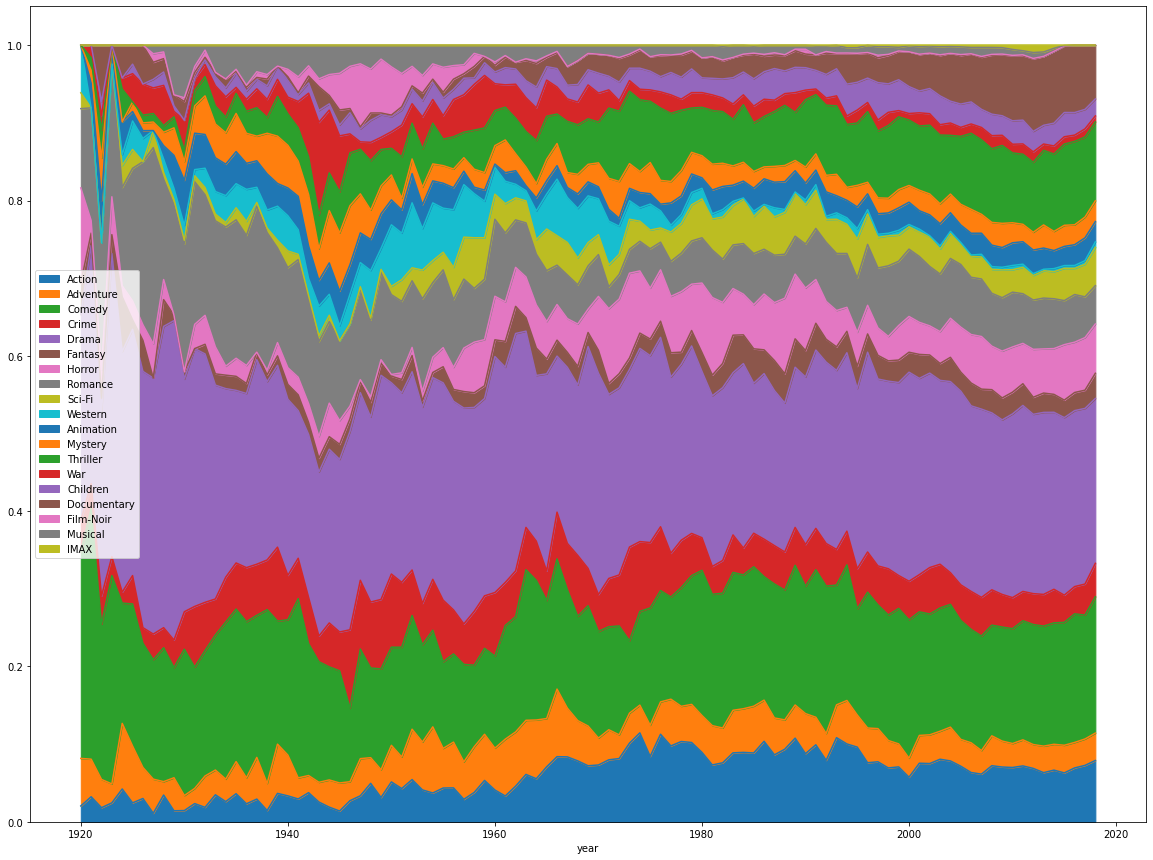

Alternative way to visualize the data is to build a pivot table. The principle is basically the same.

In [14]:
movies
    .filter { year >= 1920 && genres  != "(no genres listed)" }
    .split { genres }.by("|").intoRows()
    .sortBy { year and genres}
    .groupBy { year }
    .pivot(inward = false) { genres }
    .count()


... showing only top 20 of 99 rows DataFrame [99 x 20]

Drama is the most popular all these years! I was a bit shocked when discovered it.

Now let's move to th next part.

### Find the most tagged movie

Now, when you're familiar with basics, we can skip several things, but here is what we'e going to do:

1. Read tags
1. Join movies with tags
1. group by movie id
1. aggregate all tags into set (to remove duplicates if any)
1. get 10 top-tagged movies
1. ???
1. PROFIT

First let's read tags data and explare it's schema.

In [15]:
val tags = DataFrame.read("ml-latest/tags.csv")
tags.schema()

userId: Int
movieId: Int
tag: String?
timestamp: Int


Nothing too shocking here. Optional `tag`, `userId`, `movieId`, and `timestamp`. We're note interested in `userId` and `timestamp` this time. Indeed, we should join on `movieId`.

In [16]:
val moviesWithTags = movies.leftJoin(tags){ movieId }
moviesWithTags

... showing only top 20 of 1121114 rows DataFrame [1121114 x 7]

Quite simple, right? Just usual SQL-like syntax, with auto-completion in lamda, returning JOIN predicate.

Now let's group and aggregate it

In [17]:
moviesWithTags
    .groupBy{ movieId }
    .aggregate { 
        title.first() into "title"
        tag.dropNulls().toSet() into "tags"
    }

... showing only top 20 of 58098 rows DataFrame [58098 x 3]

Nothing new in grouping, but here we find the new syntax of aggregation. 

First, we **know** that when we group by `movieId` every `movieId` will match exactly one title. It means that in every group we can select any `title`. `first` is on of ways to achieve this goal. Potentially the fastest one.

Second, we gather all tags into one set. Notice how we work with `tag` column as it was just usual collection. Miraclous, isn't it? Of course, in reality it's not a collection, but it's an object of type `DataColumn` which allows exporting data into some collctions. And on this sollections w ealready can make any transformations we want.

Now we should find most tagged movies. For that we should sort by number of tags in descending order

In [18]:
moviesWithTags
    .groupBy{ movieId }
    .aggregate { 
        title.first() into "title"
        tag.dropNulls().toSet() into "tags"
    }
    .sortByDesc { expr { "tags"<List<String>>().count() } }
    .take(10)


DataFrame [10 x 3]

OK, indeed there are lots of tags :) Let's output the number of tags into separate column

In [19]:
moviesWithTags
    .groupBy { movieId }
    .aggregate { 
        title.first() into "title"
        tag.dropNulls().toSet() into "tags"
    }
    .add("tagNumber") {
        "tags"<List<String>>().count()
    }
    .sortByDesc { expr { "tags"<List<String>>().count() } }
    .take(10)


DataFrame [10 x 4]

Wow, it's crazy! 1032 tags. But I'm not really suprised, I love these movies too (except "Forrest Gump" and "The Silence of Lambs").

In [20]:
moviesWithTags
    .groupBy{ movieId }
    .aggregate { 
        title.first() into "title"
        tag.dropNulls().toSet() into "tags"
    }
    .add("tagNumber"){
        "tags"<List<String>>().count()
    }
    .sortByDesc { expr { "tags"<List<String>>().count() } }[0]["tags"]

[sci-fi, space action, classic sci-fi, Harrison Ford, must see, Class sci-fi, Mystical space epic, space adventure, good vs evil, oldie but goodie, Science Fiction, orca, epic adventure, good versus evil, jedi, space epic, space, trilogy, classic, drama, blockbuster, great story, Star Wars, hero's journey, action, Cool, have not seen it, haven't seen it, 1970s, annimation, fiction, fairy tale, legendary, future, inspiring, classic adventure, fantasy action, critically acclaimed, EPIC, 70s, action adventure, epic, fantasy, saga, cult classic, Alec Guinness, Anthony Daniels, Carrie Fisher, David Prowse, Denis Lawson, George Lucas, James Earl Jones, John Williams, Kenny Baker, Mark Hamill, Peter Cushing, Peter Mayhew, Epic, luke skywalker, scifi cult, good for kids, Fantastic Sci fi, Solid Sci fi, best movie ever, cult, kids and family, star wars, bewbs, action, scifi, adventure, aliens, original plot, space travel, starship pilots, Action, anime, Comedy, Nerd, entertaining, romance, sci-

And yes, I should admit, some of these tags are crazy.

